# Задание

Для выполнения задания используйте набор данных boston из библиотеки sklearn 
https://scikit-learn.org/stable/datasets/index.html#boston-dataset


1. Загрузите данные с помощью библиотеки sklearn.
2. Разделите выборку на обучающую (75%) и контрольную (25%).
3. Заведите массив для объектов DecisionTreeRegressor (они будут использоваться в качестве базовых алгоритмов) и для вещественных чисел (коэффициенты перед базовыми алгоритмами).
4. В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с отклонением истинных значений от предсказанных.
5. Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.
6. В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.
7. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?
8. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?
9. Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке MSE.

1. Загрузите данные с помощью библиотеки sklearn.
2. Разделите выборку на обучающую (75%) и контрольную (25%).

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = datasets.load_boston()

X, y = df.data, df.target

N_train = int(len(X) * 0.75)

X_train, y_train, X_test, y_test = X[:N_train], y[:N_train], X[N_train:], y[N_train:]

4. В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с отклонением истинных значений от предсказанных.
5. Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.
6. В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def grad(z, y):
    return y - z

def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]


def gbm_train(X_train, y_train, max_depth=5, iters=50, coef=0.9):
    algos, coefs = [], []
    
    target = y_train
    for i in range(iters):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X_train, target)
        algos.append(tree)
        
        if isinstance(coef, (int, float)):
            coefs.append(coef)
        else:
            coefs.append(coef(i))
            
        target = grad(gbm_predict(X_train, algos, coefs), y_train)
        
    return algos, coefs

In [9]:
algos, coefs = gbm_train(X_train, y_train)
mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))

29.763190593173984

7. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?

In [10]:
algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.9 / (1.0 + i))
mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))

23.160646605739455

8. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?

In [13]:
algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.1, iters=100)

In [14]:
metrics = []

for i in range(100):
    pred = gbm_predict(X_test, algos[:i], coefs[:i])
    mse = mean_squared_error(y_test, pred)
    metrics.append(mse)

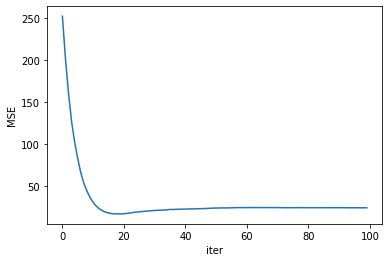

In [15]:
plt.plot(np.arange(100), metrics)
plt.xlabel('iter')
plt.ylabel('MSE');

In [16]:
metrics = []

for depth in [3, 5, 10]:
    algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.1, max_depth=depth)
    mse = mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))
    metrics.append(mse)

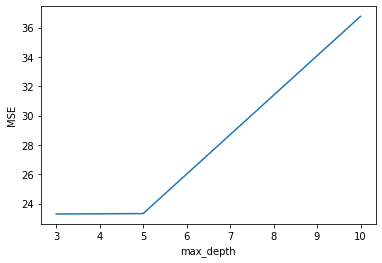

In [17]:
plt.plot([3, 5, 10], metrics)
plt.xlabel('max_depth')
plt.ylabel('MSE');

Из графиков можно сделать следующие выводы:
1. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.
2. С ростом глубины деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

9. Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке MSE.

In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
mean_squared_error(y_test, lr.predict(X_test))

68.14469073150657